In [1]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score, roc_curve, precision_recall_curve, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import time # To measure training time
import shap # For model interpretability
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Read data from previous step
base_saving_place = "../../data/processed/NeurIPS"
sample_size = 10000
X_train = pd.read_csv(f"{base_saving_place}/X_train.csv").head(sample_size)
X_test = pd.read_csv(f"{base_saving_place}/X_test.csv").head(sample_size)
y_train = pd.read_csv(f"{base_saving_place}/y_train.csv").head(sample_size)
y_test = pd.read_csv(f"{base_saving_place}/y_test.csv").head(sample_size)
X_train_processed = pd.read_csv(f"{base_saving_place}/X_train_without_resampling.csv").head(sample_size)
X_test_processed = pd.read_csv(f"{base_saving_place}/X_test_without_resampling.csv").head(sample_size)

In [17]:
y_train.head()

,fraud_bool
0,0
1,0
2,0
3,0
4,0


In [4]:
# --- 8. Resampling the Training Data using SMOTE ---
print("\nApplying SMOTE to the training data to handle class imbalance...")
minority_class_count = y_train.value_counts().min()
k_neighbors_smote = min(5, minority_class_count - 1) if minority_class_count > 1 else 1

if k_neighbors_smote < 1 and minority_class_count <=1 : 
    print(f"WARNING: Minority class in training set has only {minority_class_count} sample(s).")
    print("SMOTE cannot be applied effectively or may fail. Consider alternative strategies or more data.")
    print("Proceeding without SMOTE for now.")
    X_train_resampled = X_train_processed
    y_train_resampled = y_train
else:
    smote = SMOTE(random_state=42, k_neighbors=k_neighbors_smote)
    try:
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)
        print("SMOTE applied successfully.")
        print(f"Shape of X_train_resampled: {X_train_resampled.shape}")
        print(f"Shape of y_train_resampled: {y_train_resampled.shape}")
        print(f"Fraud distribution in y_train_resampled: \n{pd.Series(y_train_resampled).value_counts(normalize=True)}")
    except ValueError as e:
        print(f"Error during SMOTE: {e}")
        print("This might happen if the minority class count is too low even after adjusting k_neighbors.")
        print("Proceeding with original (imbalanced) training data for now.")
        X_train_resampled = X_train_processed
        y_train_resampled = y_train


Applying SMOTE to the training data to handle class imbalance...
SMOTE applied successfully.
Shape of X_train_resampled: (19798, 66)
Shape of y_train_resampled: (19798, 1)
Error during SMOTE: Data must be 1-dimensional, got ndarray of shape (19798, 1) instead
This might happen if the minority class count is too low even after adjusting k_neighbors.
Proceeding with original (imbalanced) training data for now.


In [5]:
# --- 9. SVM Model Training and Hyperparameter Tuning ---
print("\n--- SVM Model Training and Hyperparameter Tuning ---")

# Define the parameter grid for SVM
# Note: A smaller grid is used here for faster execution on the sample data.
# For the full dataset, you might want to explore a wider range or more parameters.
# Common kernels: 'rbf', 'linear'. 'poly' can be slow.
# If using 'linear' kernel, 'gamma' is not used.
param_grid_svm = {
    'C': [0.1, 1, 10], # Regularization parameter
    'gamma': ['scale', 'auto', 0.01, 0.1], # Kernel coefficient for 'rbf'
    'kernel': ['rbf'] # Start with rbf, can add 'linear'
    # 'class_weight': ['balanced'] # SMOTE handles imbalance, but can be an alternative/addition
}

cv_stratified = StratifiedKFold(n_splits=3, shuffle=True, random_state=42) 

grid_search_svm = GridSearchCV(
    estimator=SVC(probability=True, random_state=42), 
    param_grid=param_grid_svm,
    scoring='average_precision', 
    cv=cv_stratified,
    verbose=2, 
    n_jobs=-1 
)


--- SVM Model Training and Hyperparameter Tuning ---


In [6]:
print("Starting GridSearchCV for SVM...")
start_time_svm_train = time.time()
grid_search_svm.fit(X_train_resampled, y_train_resampled)
end_time_svm_train = time.time()
svm_training_time = end_time_svm_train - start_time_svm_train

best_svm_model = grid_search_svm.best_estimator_
print("\nBest SVM Parameters found by GridSearchCV:")
print(grid_search_svm.best_params_)
print(f"Best SVM Average Precision (PR AUC) score during CV: {grid_search_svm.best_score_:.4f}")
print(f"SVM Training Time (including GridSearchCV): {svm_training_time:.2f} seconds")

Starting GridSearchCV for SVM...
Fitting 3 folds for each of 12 candidates, totalling 36 fits


C:\Users\seksc\Documents\SGH\sem6\licencjat\.venv\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Best SVM Parameters found by GridSearchCV:
{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Best SVM Average Precision (PR AUC) score during CV: 0.0759
SVM Training Time (including GridSearchCV): 37.17 seconds


In [7]:
# --- 10. Evaluate Best SVM Model on the Test Set ---
print("\n--- Evaluating Best SVM Model on Test Set ---")
y_pred_svm = best_svm_model.predict(X_test_processed)
y_proba_svm = best_svm_model.predict_proba(X_test_processed)[:, 1] 


--- Evaluating Best SVM Model on Test Set ---


In [8]:
# Calculate individual metrics
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm_fraud = precision_score(y_test, y_pred_svm, pos_label=1, zero_division=0)
recall_svm_fraud = recall_score(y_test, y_pred_svm, pos_label=1, zero_division=0) # Sensitivity for fraud
f1_svm_fraud = f1_score(y_test, y_pred_svm, pos_label=1, zero_division=0)

precision_svm_weighted = precision_score(y_test, y_pred_svm, average='weighted', zero_division=0)
recall_svm_weighted = recall_score(y_test, y_pred_svm, average='weighted', zero_division=0)
f1_svm_weighted = f1_score(y_test, y_pred_svm, average='weighted', zero_division=0)


print("\nSVM Detailed Metrics on Test Set:")
print(f"Accuracy: {accuracy_svm:.4f}")
print(f"Precision (for fraud class=1): {precision_svm_fraud:.4f}")
print(f"Recall/Sensitivity (for fraud class=1): {recall_svm_fraud:.4f}")
print(f"F1-score (for fraud class=1): {f1_svm_fraud:.4f}")
print("---")
print(f"Weighted Precision: {precision_svm_weighted:.4f}")
print(f"Weighted Recall/Sensitivity: {recall_svm_weighted:.4f}")
print(f"Weighted F1-score: {f1_svm_weighted:.4f}")


SVM Detailed Metrics on Test Set:
Accuracy: 0.9873
Precision (for fraud class=1): 0.0000
Recall/Sensitivity (for fraud class=1): 0.0000
F1-score (for fraud class=1): 0.0000
---
Weighted Precision: 0.9748
Weighted Recall/Sensitivity: 0.9873
Weighted F1-score: 0.9810


In [9]:
print("\nSVM Classification Report on Test Set (provides per-class and average metrics):")
try:
    print(classification_report(y_test, y_pred_svm, target_names=['Legit (0)', 'Fraud (1)'], zero_division=0))
except ValueError: 
    print(classification_report(y_test, y_pred_svm, zero_division=0))


SVM Classification Report on Test Set (provides per-class and average metrics):
              precision    recall  f1-score   support

   Legit (0)       0.99      1.00      0.99      9873
   Fraud (1)       0.00      0.00      0.00       127

    accuracy                           0.99     10000
   macro avg       0.49      0.50      0.50     10000
weighted avg       0.97      0.99      0.98     10000


SVM Confusion Matrix on Test Set:
[[9873    0]
 [ 127    0]]


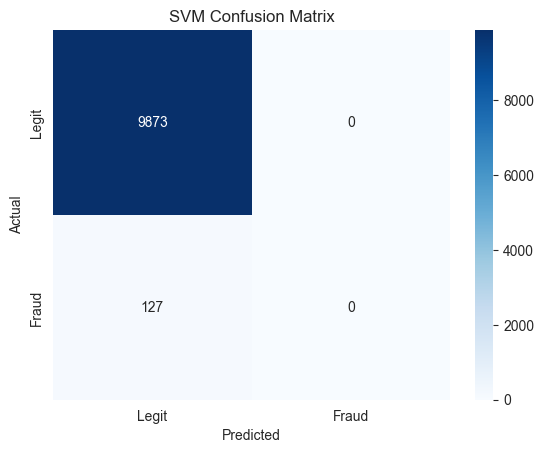

In [10]:
print("SVM Confusion Matrix on Test Set:")
cm_svm = confusion_matrix(y_test, y_pred_svm)
print(cm_svm)

sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', xticklabels=['Legit', 'Fraud'], yticklabels=['Legit', 'Fraud'])
plt.title('SVM Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


SVM AUC-ROC on Test Set: 0.7330
SVM AUC-PR (Average Precision) on Test Set: 0.0715


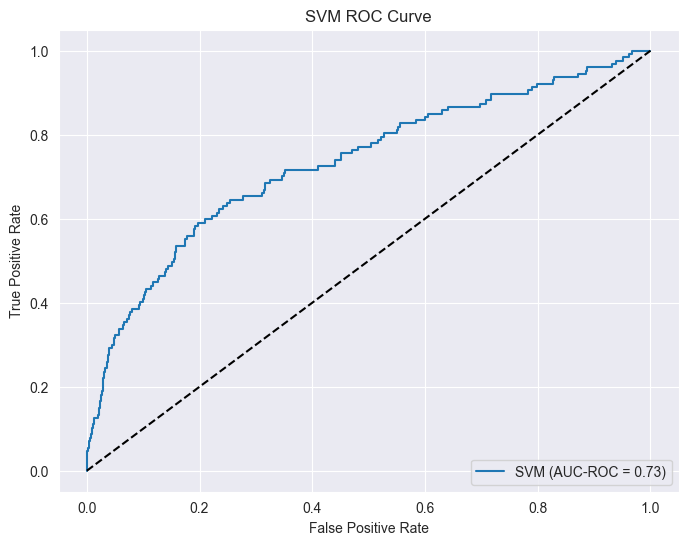

In [11]:
roc_auc_svm = roc_auc_score(y_test, y_proba_svm)
pr_auc_svm = average_precision_score(y_test, y_proba_svm) 

print(f"\nSVM AUC-ROC on Test Set: {roc_auc_svm:.4f}")
print(f"SVM AUC-PR (Average Precision) on Test Set: {pr_auc_svm:.4f}") 

# Plot ROC Curve
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_proba_svm)
plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC-ROC = {roc_auc_svm:.2f})')
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

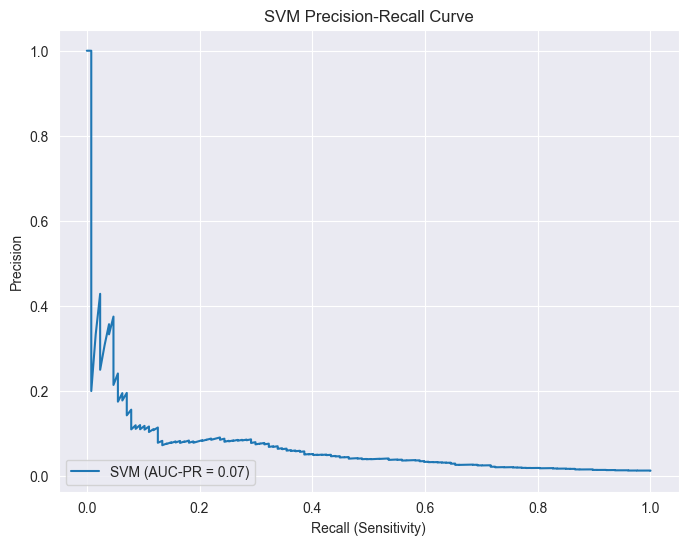

In [12]:
# Plot Precision-Recall Curve
precision_svm_curve, recall_svm_curve, _ = precision_recall_curve(y_test, y_proba_svm)
plt.figure(figsize=(8, 6))
plt.plot(recall_svm_curve, precision_svm_curve, label=f'SVM (AUC-PR = {pr_auc_svm:.2f})')
plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision')
plt.title('SVM Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

In [13]:
processed_feature_names = ['income', 'name_email_similarity', 'prev_address_months_count', 'current_address_months_count', 'days_since_request', 'intended_balcon_amount', 'zip_count_4w', 'velocity_6h', 'velocity_24h', 'velocity_4w', 'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w', 'credit_risk_score', 'bank_months_count', 'proposed_credit_limit', 'session_length_in_minutes', 'device_distinct_emails_8w', 'customer_age_10', 'customer_age_20', 'customer_age_30', 'customer_age_40', 'customer_age_50', 'customer_age_60', 'customer_age_70', 'customer_age_80', 'customer_age_90', 'payment_type_AA', 'payment_type_AB', 'payment_type_AC', 'payment_type_AD', 'payment_type_AE', 'employment_status_CA', 'employment_status_CB', 'employment_status_CC', 'employment_status_CD', 'employment_status_CE', 'employment_status_CF', 'employment_status_CG', 'housing_status_BA', 'housing_status_BB', 'housing_status_BC', 'housing_status_BD', 'housing_status_BE', 'housing_status_BF', 'housing_status_BG', 'source_INTERNET', 'source_TELEAPP', 'device_os_linux', 'device_os_macintosh', 'device_os_other', 'device_os_windows', 'device_os_x11', 'month_0', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'email_is_free', 'phone_home_valid', 'phone_mobile_valid', 'has_other_cards', 'foreign_request', 'keep_alive_session']

In [14]:
# --- 11. SVM Interpretability with SHAP ---
print("\nSVM Interpretability using SHAP:")
print("Note: SHAP with KernelExplainer can be computationally intensive.")
print("Using a sample of the training data as background and a sample of test data for explanation.")

# Prepare data for SHAP:
# SHAP works best with DataFrames if you want feature names directly in plots.
# If processed_feature_names is None, SHAP will use integer column indices.

if processed_feature_names:
    X_train_shap_background = pd.DataFrame(X_train_resampled, columns=processed_feature_names)
    X_test_shap_sample = pd.DataFrame(X_test_processed, columns=processed_feature_names)
else: # Fallback to NumPy arrays if feature names reconstruction failed
    X_train_shap_background = X_train_resampled
    X_test_shap_sample = X_test_processed
    print("Warning: Feature names not available for SHAP plots; using column indices.")



SVM Interpretability using SHAP:
Note: SHAP with KernelExplainer can be computationally intensive.
Using a sample of the training data as background and a sample of test data for explanation.


In [15]:
# Sample the background data for KernelExplainer (e.g., 100 samples)
# Adjust nsamples based on your dataset size and computational resources
nsamples_background = min(100, X_train_shap_background.shape[0])
background_data = shap.sample(X_train_shap_background, nsamples_background, random_state=42)

SHAP KernelExplainer initialized.
Calculating SHAP values for 50 test instances...


  0%|          | 0/50 [00:00<?, ?it/s]

SHAP values calculation time: 1657.94 seconds

Generating SHAP Summary Plot (Feature Importance):


<Figure size 640x480 with 0 Axes>

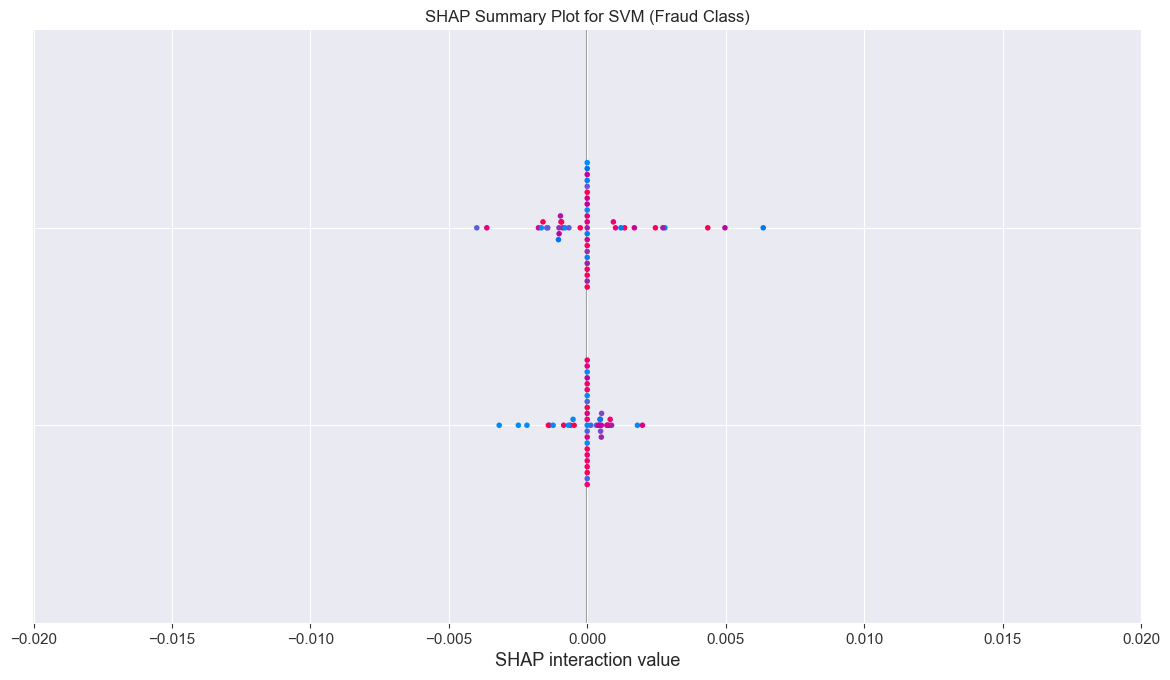

In [16]:
# Create SHAP KernelExplainer
# We need the model's predict_proba function for SHAP
try:
    explainer_svm = shap.KernelExplainer(best_svm_model.predict_proba, background_data)
    print("SHAP KernelExplainer initialized.")

    # Explain a sample of the test set (e.g., 50 samples)
    # Adjust nsamples_test_shap based on your needs
    nsamples_test_shap = min(50, X_test_shap_sample.shape[0])
    if nsamples_test_shap > 0:
        if isinstance(X_test_shap_sample, pd.DataFrame):
            test_data_for_shap = X_test_shap_sample.sample(nsamples_test_shap, random_state=42)
        else: # Handle NumPy array case
            indices = np.random.choice(X_test_shap_sample.shape[0], nsamples_test_shap, replace=False)
            test_data_for_shap = X_test_shap_sample[indices]
        
        print(f"Calculating SHAP values for {nsamples_test_shap} test instances...")
        start_time_shap = time.time()
        # We are interested in the SHAP values for the positive class (fraud=1)
        shap_values_svm = explainer_svm.shap_values(test_data_for_shap, nsamples='auto') # nsamples='auto' or a fixed number
        end_time_shap = time.time()
        print(f"SHAP values calculation time: {end_time_shap - start_time_shap:.2f} seconds")

        # SHAP values for multiclass (predict_proba) returns a list of arrays (one per class)
        # For binary classification, shap_values_svm[1] corresponds to the positive class (fraud)
        
        # It's possible KernelExplainer returns a single array for binary if link='identity' was used,
        # but with predict_proba, it's usually a list. Check the structure.
        if isinstance(shap_values_svm, list) and len(shap_values_svm) == 2:
            shap_values_for_positive_class = shap_values_svm[1]
        else: # Fallback if the structure is different (e.g. single array)
            shap_values_for_positive_class = shap_values_svm

        print("\nGenerating SHAP Summary Plot (Feature Importance):")
        # Use the actual test_data_for_shap (which might be a DataFrame or NumPy array)
        shap.summary_plot(shap_values_for_positive_class, test_data_for_shap, feature_names=processed_feature_names if processed_feature_names else None, show=False)
        plt.title("SHAP Summary Plot for SVM (Fraud Class)")
        plt.show()
        
        # Example of a force plot for the first explanation
        # print("\nGenerating SHAP Force Plot for the first test instance explained:")
        # shap.initjs() # Required for force plots in some environments
        # display(shap.force_plot(explainer_svm.expected_value[1], shap_values_for_positive_class[0,:], test_data_for_shap.iloc[0,:] if isinstance(test_data_for_shap, pd.DataFrame) else test_data_for_shap[0,:], feature_names=processed_feature_names))
        # plt.show() # May not be needed if display() works

    else:
        print("Not enough test samples to generate SHAP explanations.")

except Exception as e:
    print(f"Error during SHAP value calculation or plotting: {e}")
    print("SHAP interpretability might be limited for this model or data sample.")